# Amplitude and phase detuning

This particle tracking simulation uses a simple model of a circular machine built of a linear cell and a sextupole in thin lense approximation.
For simplicity, we asume twiss functions of $\beta_x=1$ and $\alpha_x=0$ at the location of the sextupole, such that the transfer map of the cell is a simple rotation in phase space.

A number of probe particles equally distributed in phase space is launched and tracked around the machine for a given number of turns.
The machine tune and the strength of the sextupole can be adjusted.

The plots at the bottom show the detuning effect each of the probe particle has experienced as compared to a linear machine. The detuning can be viewed with different turn averaging from 1 (turn-by-turn) over 3 (3-turn motion) up to the maximum (average over all simulated turns). 

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import nonlinear_tracking

In [11]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('flow', (
    # Edit this gradient at https://eltos.github.io/gradient/#flow=1D4049-029C8E-FFDB69-EA5F40-5A1F29
    (0.000, (0.114, 0.251, 0.286)),
    (0.250, (0.008, 0.612, 0.557)),
    (0.500, (1.000, 0.859, 0.412)),
    (0.750, (0.918, 0.373, 0.251)),
    (1.000, (0.353, 0.122, 0.161))))
#cmap

In [3]:
q = 2/3 + 0.013  # tune of machine
k2l = 0.1        # sextupole strength (mad-x sign convention)
beta_x = 1       # beta function at sextupole

In [4]:
# Separatrix
r = round(3*q)/3
d = q - r
S = -1/2*beta_x**(3/2)*k2l
h = 4*np.pi*d/S
print(f'Distance of tune q={q:g} to resonance r={r:g} is d={d:g}')

Distance of tune q=0.679667 to resonance r=0.666667 is d=0.013


In [5]:
# generate 100x100 probe particles
xmax = np.abs(2*h)
rastersize = 100
particles = nonlinear_tracking.make_probe_particles_grid(rastersize, xmax, xmax)
x0, px0 = particles.reshape((2,rastersize,rastersize))
amplitude0 = (x0**2 + px0**2)**0.5
angle0 = np.arctan2(px0,x0)

In [6]:
%%time

# run simulation
with np.errstate(all='ignore'): # supress overflow errors for lost particles
    ncells, q, k2l, k3l, particle_coordinates, particle_amplitude, particle_angle, particle_tune, = \
    nonlinear_tracking.simulation(
        particles = particles, q = q, k2l = k2l,
        nturns = 1000,    # number of turns
    )

print('Simulation of {} particles over {} turns complete'.format(*particle_amplitude.shape))

Simulation of 10000 particles over 1001 turns complete
CPU times: total: 1.47 s
Wall time: 1.49 s


In [7]:
phase_advance = 2*np.pi * particle_tune.reshape((rastersize,rastersize,-1))

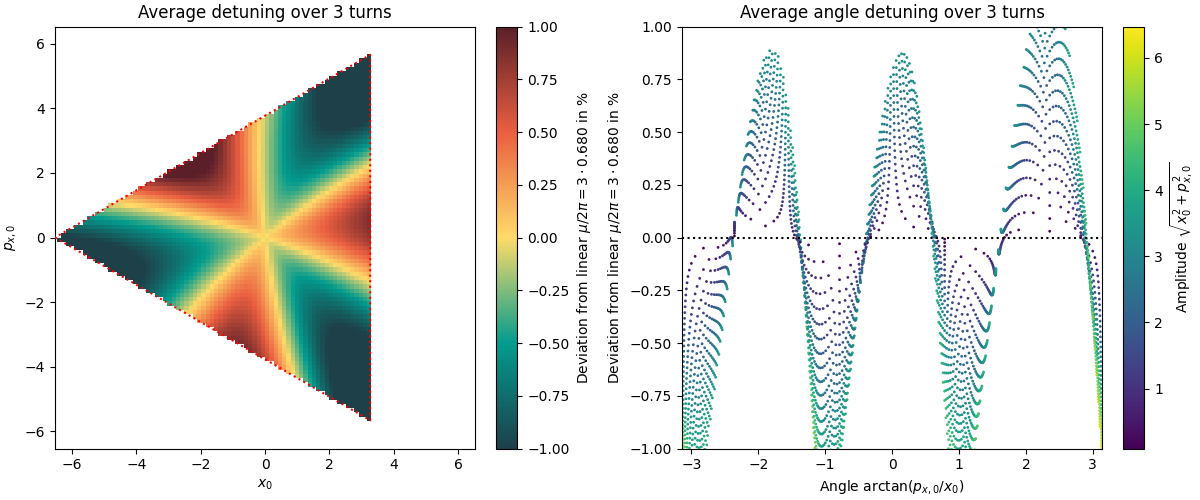

In [8]:
%matplotlib widget

out = widgets.Output()
with out:
    fig, (ax, ah) = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)
colorbars = []
    
def update(*args):
    while colorbars: colorbars.pop().remove()
    plot(ax, ctrl_plot1_type.value)
    plot(ah, ctrl_plot2_type.value)
    
def plot(ax, plot_type):
    
    n = ctrl_turn_avg.value
    
    # Average detuning over the first n turns in percent
    detuning = np.mean(phase_advance[:,:,:n], axis=2) / (2*np.pi)
    
    if ctrl_hide_unstable.value:
        detuning[~np.isfinite(phase_advance[:,:,-1])] = np.nan
        detuning[nonlinear_tracking.kobayashi_hamiltonian_normalized(x0, px0, h) > 1] = np.nan
    if 'show round beam':
        detuning[amplitude0 > xmax] = np.nan
        
    if ctrl_scale.value: # manual scale (diverging)
        detuning_range = q+q*ctrl_scale.value/100*np.array([-1, 1])
    else: # auto-scale (not diverging)
        detuning_range = np.array([np.nanmin(detuning), np.nanmax(detuning)])
    
    # relative scale
    if ctrl_relative.value:
        detuning = 100 * ( detuning - q ) / q
        detuning_range = 100 * ( detuning_range - q) / q #q+q*detuning_range/100
    
    
    # clear plots
    while ax.collections: ax.collections.pop()
    while ax.lines: ax.lines.pop()
    while ax.patches: ax.patches.pop()
    ax.legend([]).set_visible(False)
    
    # phase space
    #########################    
    if plot_type == 0:
        mesh = ax.pcolormesh(x0, px0, detuning, cmap=cmap, vmin=detuning_range[0], vmax=detuning_range[1])
        colorbars.append(fig.colorbar(mesh, ax=ax, label=f'Deviation from linear $\\mu/2\\pi={n}\\cdot{q:.3f}$ in %' if ctrl_relative.value else f'Phase advance $\\mu/2\\pi$'))#, label=f'Phase advance for {n} turn(s)'))
    
        # separatrix
        ax.plot(h*np.array([2,-1,-1,2]), h*np.array([0,3**.5,-3**.5,0]), ':', c='r' if ctrl_hide_unstable.value else 'w', zorder=100, label='Separatrix')
        
        ax.set(title=f'Average detuning over {n} turns',
              xlabel='$x_0$', ylabel='$p_{x,0}$',
              xlim=(np.min(x0), np.max(x0)), ylim=(np.min(px0), np.max(px0)))

    
    # histogram plot
    ######################### 
    if plot_type == 3:
        ax.hist(detuning.flatten(), bins=rastersize, color='tab:blue', range=detuning_range)
        ax.set(title='Histogram',
               xlabel=f'Deviation from linear $\\mu/2\\pi={n}\\cdot{q:.3f}$ in %' if ctrl_relative.value else f'Phase advance $\\mu/2\\pi$',
               ylabel='Number of Particles',
               )
        ax.relim()
        ax.autoscale()
        
    # phase detuning plot
    ######################### 
    if plot_type == 1:
        scatter = ax.scatter(angle0, detuning, 1, c=amplitude0)
        ax.axhline((100*(r-q)/q) if ctrl_relative.value else r, ls=':', color='r', label='3rd order resonance')
        ax.axhline(0 if ctrl_relative.value else q, ls=':', color='k', label=f'Linear tune $q={q:g}$')
        ax.set(title=f'Average angle detuning over {n} turns',
               xlabel='Angle $\\mathrm{arctan}(p_{x,0}/x_0)$',
               ylabel=f'Deviation from linear $\\mu/2\\pi={n}\\cdot{q:.3f}$ in %' if ctrl_relative.value else f'Phase advance $\\mu/2\\pi$',
               xlim=(-np.pi, np.pi), ylim=detuning_range)
        colorbars.append(fig.colorbar(scatter, ax=ax, label='Amplitude $\\sqrt{x_0^2+p_{x,0}^2}$'))
    
    # amplitude detuning plot
    ######################### 
    if plot_type == 2 or plot_type == 2.5:
        scatter = ax.scatter(amplitude0 if plot_type==2 else nonlinear_tracking.kobayashi_hamiltonian_normalized(x0, px0, h), detuning, 1, c=angle0)
        ax.axhline((100*(r-q)/q) if ctrl_relative.value else r, ls=':', color='r', label='3rd order resonance')
        ax.axhline(0 if ctrl_relative.value else q, ls=':', color='k', label=f'Linear tune $q={q:g}$')
        ax.set(title=f'Average amplitude detuning over {n} turns',
               xlabel='Amplitude $\\sqrt{x_0^2+p_{x,0}^2}=\\sqrt{2 J_{x,0}}$' if plot_type == 2 else 'Kobayashi hamiltonian normalized to value at separatrix',
               ylabel=f'Deviation from linear $\\mu/2\\pi={n}\\cdot{q:.3f}$ in %' if ctrl_relative.value else f'Phase advance $\\mu/2\\pi$',
               xlim=(0, np.max(x0) if plot_type==2 else 1.05), ylim=detuning_range)
        colorbars.append(fig.colorbar(scatter, ax=ax, label='Angle $\\mathrm{arctan}(p_{x,0}/x_0)$'))
    
    # phase detuning plot
    ######################### 
    if plot_type == 4 or plot_type == 4.5:
        scatter = ax.scatter(angle0, amplitude0 if plot_type==4 else nonlinear_tracking.kobayashi_hamiltonian_normalized(x0, px0, h), 1,
                             c=detuning, cmap=cmap, vmin=detuning_range[0], vmax=detuning_range[1])
        #ax.axhline((100*(r-q)/q) if ctrl_relative.value else r, ls=':', color='r', label='3rd order resonance')
        #ax.axhline(0 if ctrl_relative.value else q, ls=':', color='k', label=f'Linear tune $q={q:g}$')
        ax.set(title=f'Average detuning over {n} turns',
               xlabel='Angle $\\mathrm{arctan}(p_{x,0}/x_0)$',
               ylabel='Amplitude $\\sqrt{x_0^2+p_{x,0}^2}=\\sqrt{2 J_{x,0}}$' if plot_type == 4 else 'Kobayashi hamiltonian normalized to value at separatrix',
               xlim=(-np.pi, np.pi), ylim=(0, (1.05*np.nanmax(amplitude0[np.isfinite(detuning)])) if plot_type==4 else 1.05))
        colorbars.append(fig.colorbar(scatter, ax=ax, label=f'Deviation from linear $\\mu/2\\pi={n}\\cdot{q:.3f}$ in %' if ctrl_relative.value else f'Phase advance $\\mu/2\\pi$'))
    
    
    
ctrl_turn_avg = widgets.BoundedIntText(value=3, min=1, max=phase_advance.shape[-1], description='Turn avg.')
ctrl_scale = widgets.BoundedFloatText(value=1, min=0, max=100, step=0.5, description='Color scale')
plot_options = [('Phase space', 0), ('Detuning vs angle', 1), ('Detuning vs amplitude', 2), ('Detuning vs kobayashi', 2.5), ('Amplitude vs angle', 4), ('Kobayashi vs angle', 4.5), ('Histogram', 3)]
ctrl_plot1_type = widgets.Dropdown(value=0, options=plot_options, description='Left plot')
ctrl_plot2_type = widgets.Dropdown(value=1, options=plot_options, description='Right plot')
ctrl_hide_unstable = widgets.Checkbox(value=True, description='Show only stable particles')
ctrl_relative = widgets.Checkbox(value=True, description='Show relative tune deviation')
ctrl = widgets.HBox([ctrl_turn_avg, ctrl_plot1_type, ctrl_plot2_type, ctrl_scale, ctrl_hide_unstable, ctrl_relative], layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
for w in ctrl.children: w.observe(update)

update()

ctrl

*The phase detuning of the 3-turn-motion can be compared to the partial derivative of the effective hamiltonian (Eq. 366 and 369 in [1]) with respect to the action (Eq. 565 in [1]) from the following reference:  
[1] Chao, Alex (2002): Lecture Notes on Special Topics in Accelerator Physics. Lie Algebra Techniques for Nonlinear Dynamics (SLAC-PUB-9574). Available online at https://www.slac.stanford.edu/~achao/lecturenotes.html, checked on 2/21/2022.*

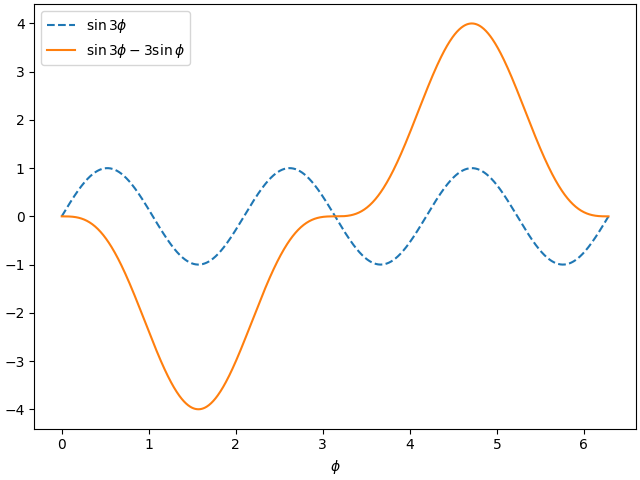

In [9]:
fig, a = plt.subplots(constrained_layout=True)
phi = np.linspace(0,2*np.pi,1000)
a.plot(phi, np.sin(3*phi), '--', label='$\\sin{3\\phi}$')
a.plot(phi, np.sin(3*phi)-3*np.sin(phi), '-', label='$\\sin{3\\phi}-3\\sin{\\phi}$')
a.set(xlabel='$\\phi$')
a.legend()
None

Formula for detuning away from resonance (derived from effective hamiltonian in chao)
$$
\frac{1}{2\pi} S\sqrt{J} \cdot 3\mu/2 \left( \frac{\sin(3\phi)}{\tan(3\mu/2)} + \cos(3\phi) 
- \frac{\sin(\phi)}{\tan(\mu/2)} - \cos(\phi) \right)
$$

0.6796666666666666

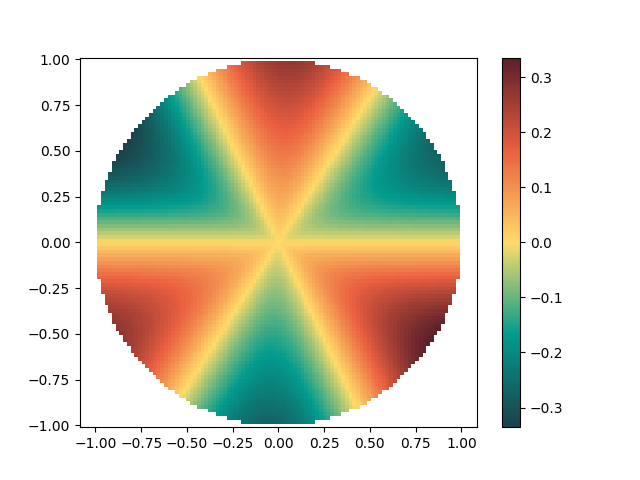

In [10]:
#q = 2/3 + 0.1   # tune of machine
mu = 2*np.pi*q
#k2l = 0.1       # sextupole strength
#S = -1/2*beta_x**(3/2)*k2l

x = px = np.linspace(-1, 1, 100)
x, px = np.meshgrid(x, px)
J = (x**2 + px**2)/2
phi = np.arctan2(px, x)

z = S * J**0.5 * 3*mu/2 / (2*np.pi) * (
        #np.sin(3*phi + 3*mu/2) / np.sin(3*mu/2)
        np.sin(3*phi) / np.tan(3*mu/2) + np.cos(3*phi)
        - ( np.sin(phi) / np.tan(mu/2) + np.cos(phi) ) )

#z = np.sin(3*phi) - 3*np.sin(phi)

z[J>1/2] = np.nan

plt.figure()
m = plt.pcolormesh(x, px, z, cmap=cmap)
plt.colorbar(m)
plt.axis('equal')
#plt.plot(phi.T, z.T)

q